In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df_train = pd.read_csv("/kaggle/input/titanic/train.csv")
df_test = pd.read_csv("/kaggle/input/titanic/test.csv")
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

from sklearn.ensemble import RandomForestClassifier

y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


# 1. Understanding the Data

In [4]:
df_train.info()
print("\n" + "-"*50 + "\n")

print("# of Missing values in train data:")
n_miss_val = df_train.isnull().sum().sort_values(ascending=False)
print(n_miss_val[n_miss_val>0])
print("# of Missing values in test data:")
n_miss_val_test = df_test.isnull().sum().sort_values(ascending=False)
print(n_miss_val_test[n_miss_val_test>0])
print("\n" + "-"*50 + "\n")

print("Distribution of Survived column:")
df_train["Survived"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

--------------------------------------------------

# of Missing values in train data:
Cabin       687
Age         177
Embarked      2
dtype: int64
# of Missing values in test data:
Cabin    327
Age       86
Fare       1
dtype: int64

--------

0    549
1    342
Name: Survived, dtype: int64

In [5]:
df_train[["Pclass", "Survived"]].groupby(["Pclass"], as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [6]:
df_train[["Sex", "Survived"]].groupby(["Sex"], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [7]:
df_train[["SibSp", "Survived"]].groupby("SibSp").agg(["count","mean"])

Survived          
         count      mean
SibSp                   
0          608  0.345395
1          209  0.535885
2           28  0.464286
3           16  0.250000
4           18  0.166667
5            5  0.000000
8            7  0.000000

In [8]:
df_train[["Parch", "Survived"]].groupby("Parch").agg(["count","mean"])

Survived          
         count      mean
Parch                   
0          678  0.343658
1          118  0.550847
2           80  0.500000
3            5  0.600000
4            4  0.000000
5            5  0.200000
6            1  0.000000

In [9]:
df_train['FamSize'] = df_train['SibSp'] + df_train['Parch']
df_train[['FamSize', 'Survived']].groupby('FamSize').agg(['count','mean'])

Survived          
           count      mean
FamSize                   
0            537  0.303538
1            161  0.552795
2            102  0.578431
3             29  0.724138
4             15  0.200000
5             22  0.136364
6             12  0.333333
7              6  0.000000
10             7  0.000000

In [10]:
df_train['FamType'] = np.where(df_train['FamSize'] == 0, "Alone", "Small_Family")
df_train.loc[df_train['FamSize'] > 3, 'FamType'] = "Large_Family"

df_train[['FamType', 'Survived']].groupby('FamType').agg(['count','mean'])

Survived          
                count      mean
FamType                        
Alone             537  0.303538
Large_Family       62  0.161290
Small_Family      292  0.578767

In [11]:
# same operations in test data
df_test['FamSize'] = df_test['SibSp'] + df_test['Parch']
df_test['FamType'] = np.where(df_test['FamSize'] == 0, "Alone", "Small_Family")
df_test.loc[df_test['FamSize'] > 3, 'FamType'] = "Large_Family"

As a result, I am happy with my new column Family Type and use it in my model.

In [12]:
# extracting the string between "," and "."
df_train["Title"] = df_train["Name"].apply(lambda x :x.split(",")[-1]).str.split(".",expand=True).loc[:,0]
df_train["Title"].value_counts()

 Mr              517
 Miss            182
 Mrs             125
 Master           40
 Dr                7
 Rev               6
 Mlle              2
 Major             2
 Col               2
 the Countess      1
 Capt              1
 Ms                1
 Sir               1
 Lady              1
 Mme               1
 Don               1
 Jonkheer          1
Name: Title, dtype: int64

In [13]:
"
title_counts = df_train["Title"].value_counts()
titles_to_keep = title_counts[title_counts>10]
titles_to_replace = list( set(title_counts.index) - set(titles_to_keep.index) )
df_train["TitleProcessed"] = df_train["Title"].replace(titles_to_replace, "Other")

df_train[["TitleProcessed", "Survived"]].groupby("TitleProcessed").agg(["count","mean"])

Survived          
                  count      mean
TitleProcessed                   
 Master              40  0.575000
 Miss               182  0.697802
 Mr                 517  0.156673
 Mrs                125  0.792000
Other                27  0.444444

In [14]:

df_test["Title"] = df_test["Name"].apply(lambda x :x.split(",")[-1]).str.split(".",expand=True).loc[:,0]

title_counts_test = df_test["Title"].value_counts() # we will keep same columns with train
titles_to_replace_test = list( set(title_counts_test.index) - set(titles_to_keep.index) )
df_test["TitleProcessed"] = df_test["Title"].replace(titles_to_replace_test, "Other")
df_test["TitleProcessed"].value_counts()

 Mr        240
 Miss       78
 Mrs        72
 Master     21
Other        7
Name: TitleProcessed, dtype: int64

<AxesSubplot:xlabel='TitleProcessed', ylabel='Age'>

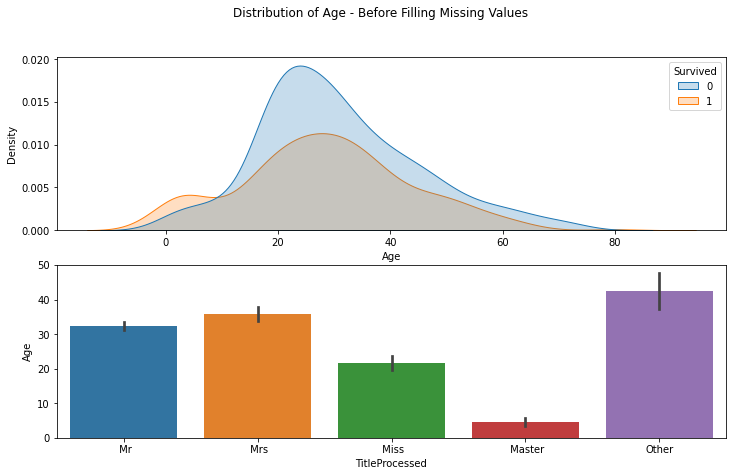

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(12, 7))
fig.suptitle('Distribution of Age - Before Filling Missing Values')
sns.kdeplot(ax=axes[0], data=df_train, x="Age", hue="Survived", shade=True)
sns.barplot(ax=axes[1], data=df_train, x="TitleProcessed", y="Age")

In [16]:
# Creating a dictionary for the average age value of each Title
titles_avg_age = df_train.groupby('TitleProcessed')['Age'].mean().round(2).to_dict()
titles_avg_age

{' Master': 4.57, ' Miss': 21.77, ' Mr': 32.37, ' Mrs': 35.9, 'Other': 42.38}

In [17]:
# Filling missing values
df_train['Age'].fillna(df_train['TitleProcessed'].map(titles_avg_age), inplace=True)
df_test['Age'].fillna(df_test['TitleProcessed'].map(titles_avg_age), inplace=True)

<AxesSubplot:xlabel='Age', ylabel='Density'>

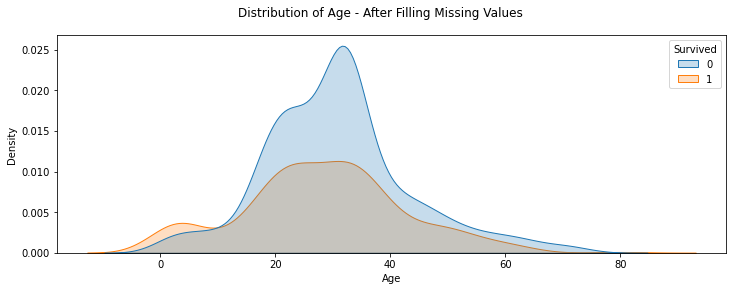

In [18]:
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
fig.suptitle('Distribution of Age - After Filling Missing Values')
sns.kdeplot(data=df_train, x="Age", hue="Survived", shade=True)

In [19]:
df_train[["Embarked", "Survived"]].groupby(["Embarked"]).agg(['count','mean'])

Survived          
            count      mean
Embarked                   
C             168  0.553571
Q              77  0.389610
S             644  0.336957

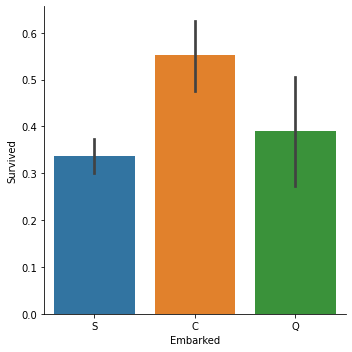

In [20]:
sns.catplot(x="Embarked", y="Survived", data=df_train, kind = "bar")

In [21]:

df_train["Embarked"].fillna("S", inplace=True)

In [22]:
df_train["Fare"].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

<AxesSubplot:xlabel='Pclass', ylabel='Fare'>

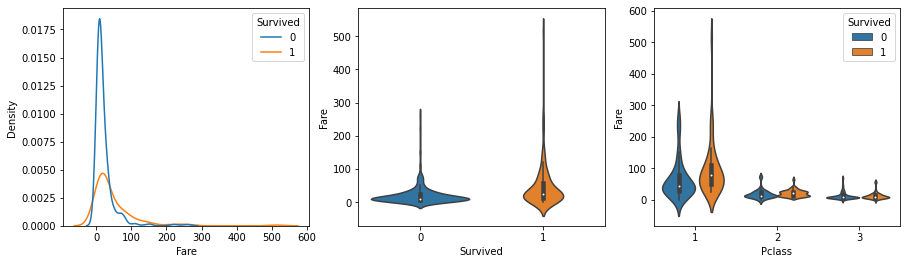

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.kdeplot(ax=axes[0], data=df_train, x="Fare", hue="Survived")
sns.violinplot(ax=axes[1], data=df_train, x="Survived", y="Fare")
sns.violinplot(ax=axes[2], data=df_train, x="Pclass", y="Fare", hue="Survived")

<AxesSubplot:xlabel='Pclass', ylabel='FareLog'>

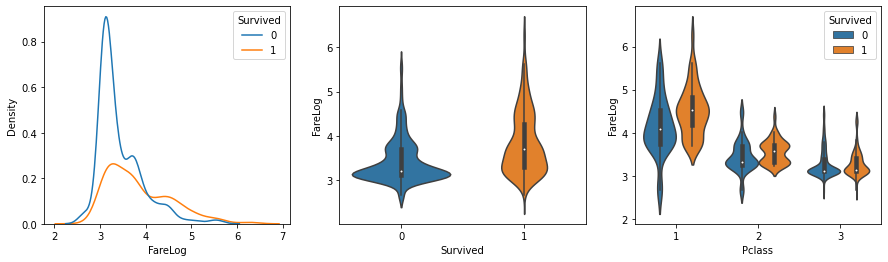

In [24]:
df_train["FareLog"] = np.log( df_train["Fare"] + df_train["Fare"].median() )

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.kdeplot(ax=axes[0], data=df_train, x="FareLog", hue="Survived")
sns.violinplot(ax=axes[1], data=df_train, x="Survived", y="FareLog")
sns.violinplot(ax=axes[2], data=df_train, x="Pclass", y="FareLog", hue="Survived")

In [25]:
# in the test data, we have 1 missing Fare. I will basicly fill it with median
# after that, apply the same log operation
df_test["Fare"].fillna(df_test["Fare"].median(), inplace=True)
df_test["FareLog"] = np.log( df_test["Fare"] + df_test["Fare"].median() )

In [26]:
print("Random 10 Tickets:")
print( df_train["Ticket"].sample(10, random_state=42) )
print()

print("Checking max repetition:")
ticket_counts = df_train["Ticket"].value_counts()
print(ticket_counts.head())
print()

print("# of unique tickets: {}".format(df_train["Ticket"].nunique()))

Random 10 Tickets:
709                2661
439          C.A. 18723
840    SOTON/O2 3101287
720              248727
39                 2651
290               19877
300                9234
333              345764
208              367231
136               11752
Name: Ticket, dtype: object

Checking max repetition:
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
Name: Ticket, dtype: int64

# of unique tickets: 681


In [27]:
print("Random 10 Cabins:")
print( df_train["Cabin"].sample(10, random_state=42) )
print()

print("Checking max repetition:")
cabin_counts = df_train["Cabin"].value_counts()
print(cabin_counts.head())
print()

print("# of unique cabins: {}".format(df_train["Cabin"].nunique()))
print("# of missing values: {}".format(df_train["Cabin"].isnull().sum()))

Random 10 Cabins:
709    NaN
439    NaN
840    NaN
720    NaN
39     NaN
290    NaN
300    NaN
333    NaN
208    NaN
136    D47
Name: Cabin, dtype: object

Checking max repetition:
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
Name: Cabin, dtype: int64

# of unique cabins: 147
# of missing values: 687


# 2. Preprocess Data

In [28]:


X_train = df_train[["Pclass","TitleProcessed","Sex","Age","FamType","FareLog","Embarked"]]
X_train = pd.get_dummies(X_train)
X_train = X_train.drop(["TitleProcessed_Other","Sex_female","FamType_Large_Family","Embarked_Q"], axis=1)
X_train.head()

,Pclass,Age,FareLog,TitleProcessed_ Master,TitleProcessed_ Miss,TitleProcessed_ Mr,TitleProcessed_ Mrs,Sex_male,FamType_Alone,FamType_Small_Family,Embarked_C,Embarked_S
0,3,22.0,3.077506,0,0,1,0,1,0,1,0,1
1,1,38.0,4.451290,0,0,0,1,0,0,1,1,0
2,3,26.0,3.108132,0,1,0,0,0,1,0,0,1
3,1,35.0,4.212930,0,0,0,1,0,0,1,0,1
4,3,35.0,3.113702,0,0,1,0,1,1,0,0,1


In [29]:
# Same operation to test data
X_test = df_test[["Pclass","TitleProcessed","Sex","Age","FamType","FareLog","Embarked"]]
X_test = pd.get_dummies(X_test)
X_test = X_test.drop(["TitleProcessed_Other","Sex_female","FamType_Large_Family","Embarked_Q"], axis=1)
X_test.head()

,Pclass,Age,FareLog,TitleProcessed_ Master,TitleProcessed_ Miss,TitleProcessed_ Mr,TitleProcessed_ Mrs,Sex_male,FamType_Alone,FamType_Small_Family,Embarked_C,Embarked_S
0,3,34.5,3.103842,0,0,1,0,1,1,0,0,0
1,3,47.0,3.065920,0,0,0,1,0,0,1,0,1
2,2,62.0,3.183941,0,0,1,0,1,1,0,0,0
3,3,27.0,3.140555,0,0,1,0,1,1,0,0,1
4,3,22.0,3.286224,0,0,0,1,0,0,1,0,1


In [30]:
y_train = df_train["Survived"]
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [31]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

# 3. Model Selection

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [33]:
# LogisticRegression
classifier = LogisticRegression(solver='liblinear')

score_unscaled = cross_val_score(classifier, X_train, y_train, cv=10).mean().round(3)
score_scaled = cross_val_score(classifier, X_train_scaled, y_train, cv=10).mean().round(3)
print("Logistic Regression")
print("Cross Val Score: {}".format(score_unscaled))
print("Cross Val Score for Scaled Data: {}".format(score_scaled))

Logistic Regression
Cross Val Score: 0.831
Cross Val Score for Scaled Data: 0.829


In [34]:
# K-Nearest Neighbors
classifier = KNeighborsClassifier()

score_unscaled = cross_val_score(classifier, X_train, y_train, cv=10).mean().round(3)
score_scaled = cross_val_score(classifier, X_train_scaled, y_train, cv=10).mean().round(3)
print("K-Nearest Neighbors")
print("Cross Val Score: {}".format(score_unscaled))
print("Cross Val Score for Scaled Data: {}".format(score_scaled))

K-Nearest Neighbors
Cross Val Score: 0.792
Cross Val Score for Scaled Data: 0.814


In [35]:
# Support Vector Classifier (SVC)
classifier = SVC()

score_unscaled = cross_val_score(classifier, X_train, y_train, cv=10).mean().round(3)
score_scaled = cross_val_score(classifier, X_train_scaled, y_train, cv=10).mean().round(3)
print("Support Vector Classifier")
print("Cross Val Score: {}".format(score_unscaled))
print("Cross Val Score for Scaled Data: {}".format(score_scaled))

Support Vector Classifier
Cross Val Score: 0.708
Cross Val Score for Scaled Data: 0.824


In [36]:
# Naive Bayes
classifier = GaussianNB()

score_unscaled = cross_val_score(classifier, X_train, y_train, cv=10).mean().round(3)
score_scaled = cross_val_score(classifier, X_train_scaled, y_train, cv=10).mean().round(3)
print("Naive Bayes")
print("Cross Val Score: {}".format(score_unscaled))
print("Cross Val Score for Scaled Data: {}".format(score_scaled))

Naive Bayes
Cross Val Score: 0.785
Cross Val Score for Scaled Data: 0.785


In [37]:
# Decision Tree Classification
classifier = DecisionTreeClassifier()

score_unscaled = cross_val_score(classifier, X_train, y_train, cv=10).mean().round(3)
score_scaled = cross_val_score(classifier, X_train_scaled, y_train, cv=10).mean().round(3)
print("Decision Tree Classifier")
print("Cross Val Score: {}".format(score_unscaled))
print("Cross Val Score for Scaled Data: {}".format(score_scaled))

Decision Tree Classifier
Cross Val Score: 0.781
Cross Val Score for Scaled Data: 0.785


In [38]:
# Random Forest Classification
classifier = RandomForestClassifier()

score_unscaled = cross_val_score(classifier, X_train, y_train, cv=10).mean().round(3)
score_scaled = cross_val_score(classifier, X_train_scaled, y_train, cv=10).mean().round(3)
print("Random Forest Classifier")
print("Cross Val Score: {}".format(score_unscaled))
print("Cross Val Score for Scaled Data: {}".format(score_scaled))

Random Forest Classifier
Cross Val Score: 0.812
Cross Val Score for Scaled Data: 0.813


# 4. Modeling and Submission

In [39]:
# SVC
classifier = SVC()
classifier.fit(X_train_scaled, y_train)

SVC()

In [40]:
y_pred = classifier.predict(X_test_scaled)

In [41]:
result = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Survived': y_pred})
result.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [42]:
result.to_csv('submission.csv', index=False)
print("Resuls are saved to submission.csv")

Resuls are saved to submission.csv


In [43]:
# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

parameters = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'sigmoid']
             }

grid = GridSearchCV(SVC(), parameters, refit = True)
grid.fit(X_train_scaled,y_train)

# printing results
print("Best Score: {}".format(grid.best_score_))
print("Best Parameters: {}".format(grid.best_params_))
print("Model: {}".format(grid.best_estimator_))

Best Score: 0.8327474734793799
Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Model: SVC(C=10, gamma=0.01)



 best score using SVC with default parameters.

